In [2]:
import numpy as np 

line = """
hello
hello
hello"""
%%writefile abc.txt
Hi



UsageError: Line magic function `%%writefile` not found.


In [10]:
f = open("qubits_psi.txt", 'w')
#for line in f: 
#   print(line)
f.write("I love you \n")
f.write("How are you")
f.close()

In [7]:
f

<_io.TextIOWrapper name='qubits_psi.txt' mode='a' encoding='cp1252'>

In [12]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

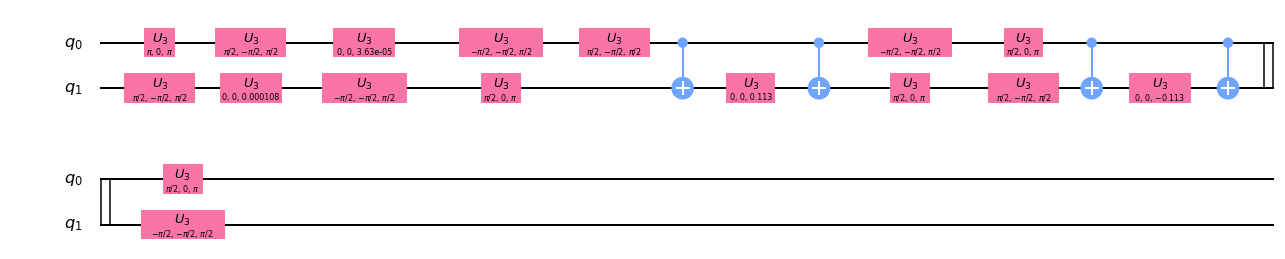

In [13]:
string = """OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[2];\nu3(pi,0,pi) q[0];\nu3(pi/2,-pi/2,pi/2) q[0];\nu3(0,0,3.6279236e-05) q[0];\nu3(-pi/2,-pi/2,pi/2) q[0];\nu3(pi/2,-pi/2,pi/2) q[0];\nu3(pi/2,-pi/2,pi/2) q[1];\nu3(0,0,0.00010816593) q[1];\nu3(-pi/2,-pi/2,pi/2) q[1];\nu3(pi/2,0,pi) q[1];\ncx q[0],q[1];\nu3(0,0,0.11268152) q[1];\ncx q[0],q[1];\nu3(-pi/2,-pi/2,pi/2) q[0];\nu3(pi/2,0,pi) q[0];\nu3(pi/2,0,pi) q[1];\nu3(pi/2,-pi/2,pi/2) q[1];\ncx q[0],q[1];\nu3(0,0,-0.11268152) q[1];\ncx q[0],q[1];\nu3(pi/2,0,pi) q[0];\nu3(-pi/2,-pi/2,pi/2) q[1];\n"""
vqe_circ = QuantumCircuit.from_qasm_str(string)
vqe_circ.draw(output = 'mpl')

In [14]:
from qiskit import ClassicalRegister
import math

Hamiltonian = """II
IZ 
ZI
ZZ
XX"""

Hamiltonian_weights = [-1.053, 0.395, -0.395, -0.011, 0.181]


circuits = []
for line in iter(Hamiltonian.splitlines()):
    circ = vqe_circ.copy()
    for index in range(len(line)):
        op = line[index]
        
        ##do nothing if Z or I
        if(op == "X"): 
            #hadamard in u3
            circ.u3(math.pi/2, 0, math.pi, index)
        elif(op == "Y"):
            circ.rx(pi/2, index)
    c = ClassicalRegister(2)
    circ.add_register(c)
    circ.measure([0], [0])
    circ.measure([1],[1])
    circuits.append(circ)

In [15]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.aqua import QuantumInstance

provider = IBMQ.get_provider(hub='ibm-q')
machine = provider.get_backend('ibmq_london')
noise_model = NoiseModel.from_backend(machine)
simulator = Aer.get_backend('qasm_simulator')
noisy_sim = QuantumInstance(backend = simulator, noise_model = noise_model)

basis_gates = noise_model.basis_gates

In [17]:
from qiskit import execute 
from qiskit.compiler import transpile 
from qiskit.tools.monitor import job_monitor

counts = []
for circ in circuits: 
    job = execute(circ, simulator, shots = 250)
    count = job.result().get_counts()
    counts.append(count)

In [18]:
counts

[{'01': 247, '10': 3},
 {'01': 245, '10': 5},
 {'01': 248, '10': 2},
 {'01': 246, '10': 4},
 {'01': 87, '11': 39, '00': 48, '10': 76}]

In [19]:
bases = ['II', 'IZ', 'ZI', 'ZZ', 'XX']

In [21]:
t = open('RBM-Check-qubits-train.txt', 'w')
h = open('RBM-Check-bases-train.txt', 'w')

for i in range(len(counts)):
    count = counts[i]
    Ham = bases[i]
    Ham_str = Ham[0] + ' ' + Ham[1]
    keys = count.keys()
    for key in keys: 
        key_str = key[0] + ' ' + key[1]
        for j in range(count[key]):
            t.write(key_str + '\n')
            h.write(Ham_str + '\n')
    

In [22]:
t.close()
h.close()

In [23]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from qucumber.nn_states import ComplexWaveFunction

from qucumber.callbacks import MetricEvaluator

import qucumber.utils.unitaries as unitaries
import qucumber.utils.cplx as cplx

import qucumber.utils.training_statistics as ts
import qucumber.utils.data as data
import qucumber

# set random seed on cpu but not gpu, since we won't use gpu for this tutorial
qucumber.set_random_seed(1234, cpu=True, gpu=False)

In [25]:
train_path = "RBM-Check-qubits-train.txt"
train_bases_path = "RBM-Check-bases-train.txt"
psi_path = "qubits_psi.txt"
bases_path = "RBM-Check-bases.txt"

train_samples, true_psi, train_bases, bases = data.load_data(
    train_path, psi_path, train_bases_path, bases_path
)

In [26]:
unitary_dict = unitaries.create_dict()
# unitary_dict = unitaries.create_dict(<unitary_name>=torch.tensor([[real part],
#                                                                   [imaginary part]],
#                            

In [27]:
nv = train_samples.shape[-1]
nh = nv

nn_state = ComplexWaveFunction(
    num_visible=nv, num_hidden=nh, unitary_dict=unitary_dict, gpu=False
)

In [28]:
epochs = 1250
pbs = 100  # pos_batch_size
nbs = pbs  # neg_batch_size
lr = 0.1
k = 10

In [29]:
def alpha(nn_state, space, **kwargs):
    rbm_psi = nn_state.psi(space)
    normalization = nn_state.normalization(space).sqrt_()
    alpha_ = cplx.norm(
        torch.tensor([rbm_psi[0][0], rbm_psi[1][0]], device=nn_state.device)
        / normalization
    )

    return alpha_


def beta(nn_state, space, **kwargs):
    rbm_psi = nn_state.psi(space)
    normalization = nn_state.normalization(space).sqrt_()
    beta_ = cplx.norm(
        torch.tensor([rbm_psi[0][1], rbm_psi[1][1]], device=nn_state.device)
        / normalization
    )

    return beta_


def gamma(nn_state, space, **kwargs):
    rbm_psi = nn_state.psi(space)
    normalization = nn_state.normalization(space).sqrt_()
    gamma_ = cplx.norm(
        torch.tensor([rbm_psi[0][2], rbm_psi[1][2]], device=nn_state.device)
        / normalization
    )

    return gamma_


def delta(nn_state, space, **kwargs):
    rbm_psi = nn_state.psi(space)
    normalization = nn_state.normalization(space).sqrt_()
    delta_ = cplx.norm(
        torch.tensor([rbm_psi[0][3], rbm_psi[1][3]], device=nn_state.device)
        / normalization
    )

    return delta_

In [30]:
period = 25
space = nn_state.generate_hilbert_space()

callbacks = [
    MetricEvaluator(
        period,
        {
            "Fidelity": ts.fidelity,
            "KL": ts.KL,
            "normα": alpha,
            # "normβ": beta,
            # "normγ": gamma,
            # "normδ": delta,
        },
        target=true_psi,
        bases=bases,
        verbose=True,
        space=space,
    )
]

In [32]:
nn_state.fit(
    train_samples,
    epochs=epochs,
    pos_batch_size=pbs,
    neg_batch_size=nbs,
    lr=lr,
    k=k,
    input_bases=train_bases,
    callbacks=callbacks,
)

KeyError: 'I'